In [1]:
import numpy as np
import scipy.signal as sig
import scipy.io
import os
import librosa
import sys

import matplotlib.pyplot as plt
font = {'family' : 'serif',
        'size'   : 10
        }
plt.rc('font', **font)

cm = 2.54
# setting path
sys.path.append("../")
from Utils.dB import *

from HN_decomposition.Subspace.preprocessing import *

(92287,)


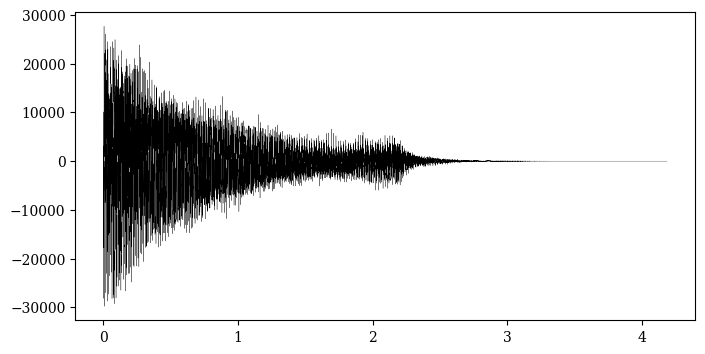

In [2]:

def filter_n_decimate(filterLength_smp : int, numBands : int, inputSignal : np.array):
    """
    args :
        - filterLength : [int]
            Digital filter length, in samples
        - numBands : [int]
            Number of frequency channels in which the signal is to be separated
        - inputSignal : [(1, N) np.array]
            Input signal 
    returns :
        - outputSignals : [numBands, N) np.array]
            Output signal"""
    signalLength_smp = np.shape(inputSignal)[0] #Input signal length
    filteredSignal = np.zeros((signalLength_smp, numBands)) #initializing the output signal
    
    #h = scipy.signal.remez(numtaps = filterLength_smp, bands = [0, 1/(2*numBands), 1/(2*numBands), .5], fs = 1)

    for i in range(numBands):
        filteredSignal[:,i] = inputSignal

    filters = np.zeros((filterLength_smp, numBands))

    n = np.arange(filterLength_smp)
    base_filter = np.zeros(filterLength_smp)
    for i in range(filters):
        filters[i] = base_filter
    
    outputSignal = filteredSignal[::numBands]
    return outputSignal


sr_hz, x = scipy.io.wavfile.read(os.path.join("..", "Data", "Piano_test", "33.wav"))

#y = filter_n_decimate(15, 4, x)


print(np.shape(x))
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(x))/sr_hz, x, 'k', linewidth = .2)
plt.show()

In [3]:
x, sr_hz = librosa.load(os.path.join("..", "Data", "Piano_test", "33.wav"))

n_fft = 1024
hop_length = n_fft

X = librosa.stft(x ,n_fft = n_fft, hop_length = hop_length)
X_squared = np.square(np.abs(X))

t_list = librosa.frames_to_samples(np.arange(np.shape(X)[1]), n_fft = n_fft, hop_length=hop_length)/sr_hz
f_list = librosa.fft_frequencies(sr = sr_hz, n_fft = n_fft)

print(f'sample rate : {sr_hz}')

#plt.pcolormesh(t_list, f_list, dB10(X), vmax = 40, vmin = -60, cmap = 'gray_r')
#plt.colorbar()
#plt.show()

sample rate : 22050


c:\Users\pelad\Documents\Scolarite\sorbonne_universite\2022_2023\Cours\Projet d'Application Musicale\Projet\ATIAM-PAM-AnalyseInstruments\Notebooks\..\Utils\dB.py:4: RuntimeWarning: divide by zero encountered in log10
  return 20*np.log10(np.abs(x))


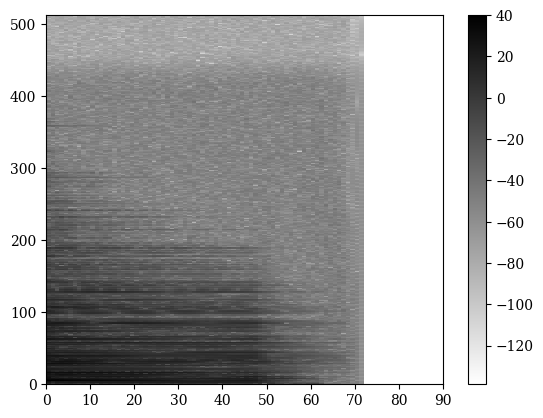

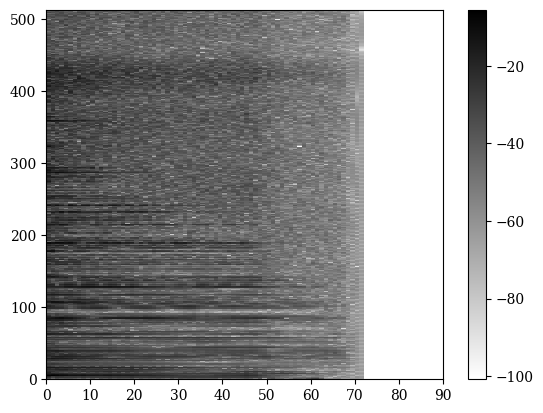

In [24]:


xWhitened = whiten_spectrum(x, n_fft = n_fft, rankFilter_bins = 101, rankFilter_rank = .5, ARFilter_length = 12)
xWhitened_stft = librosa.stft(xWhitened, n_fft = n_fft, hop_length = n_fft, center = False)

time_frame_display = 50


plt.pcolormesh(dB20(librosa.stft(x, n_fft = n_fft, hop_length = n_fft, center = False)), cmap = 'gray_r')
plt.colorbar()
plt.show()



plt.pcolormesh(dB20(xWhitened_stft), cmap = 'gray_r')
plt.colorbar()
plt.show()



In [23]:
help(np.quantile)

Help on function quantile in module numpy:

quantile(a, q, axis=None, out=None, overwrite_input=False, method='linear', keepdims=False, *, interpolation=None)
    Compute the q-th quantile of the data along the specified axis.
    
    .. versionadded:: 1.15.0
    
    Parameters
    ----------
    a : array_like
        Input array or object that can be converted to an array.
    q : array_like of float
        Quantile or sequence of quantiles to compute, which must be between
        0 and 1 inclusive.
    axis : {int, tuple of int, None}, optional
        Axis or axes along which the quantiles are computed. The default is
        to compute the quantile(s) along a flattened version of the array.
    out : ndarray, optional
        Alternative output array in which to place the result. It must have
        the same shape and buffer length as the expected output, but the
        type (of the output) will be cast if necessary.
    overwrite_input : bool, optional
        If True, then

In [6]:
AR_order = 12

for t in range(np.shape(X)[1]):
    noise_estimate = np.fft.irfft(X_filt[:,t])

noise_autocorr_vec = np.fft.irfft(X_filt[:,time_frame_display])[:AR_order+1]
#noise_autocorr_vec/=noise_autocorr_vec[0]

R = scipy.linalg.toeplitz(noise_autocorr_vec[:AR_order])
r = noise_autocorr_vec[1: AR_order+1]

AR_filt = np.concatenate((np.ones(1), -np.dot(scipy.linalg.inv(R), r)))*100
#AR_filt = np.dot(scipy.linalg.inv(R), r)
AR_sig = np.zeros(np.shape(X)[0])
AR_sig[0] = 1
AR_sig = sig.lfilter([1], AR_filt, AR_sig)
#AR_sig = sig.lfilter(AR_filt[:], [1], AR_sig)


plt.figure(figsize = (9/cm, 6/cm))
plt.plot(f_list, dB20(X[:,time_frame_display]), linewidth = .5, label = "input", color = (.5,.5,.5))
plt.plot(f_list, dB10(X_filt[:,time_frame_display]), 'k--', linewidth = .5, label = "median")
plt.plot(f_list, dB20(np.fft.rfft(AR_sig, n = n_fft)), 'k-', linewidth = .5, label = 'AR filter')

plt.xlabel(r"$f$ [Hz]")
plt.ylabel(r"$|X|$ [dB]")
plt.tight_layout()
plt.legend(loc = 'upper right')

plt.savefig(fname = os.path.join("..", "..", "PAM_overleaf", "Notes", "Come", "Figures", "filtered_spectrum.pgf"), dpi = 300, bbox_inches = "tight", format = "pgf")
plt.show()

#def fit(self, p=5):
#    ac = self.autocorr(p+1)
#    R = linalg.toeplitz(ac[:p])
#    r = ac[1:p+1]
#    self.phi = linalg.inv(R).dot(r)


plt.plot(noise_autocorr_vec)
plt.xlabel("$k$")
plt.ylabel("$R_{xx}(k)$")
plt.show()

NameError: name 'X_filt' is not defined

In [ ]:
help(scipy.signal.lfilter)

In [ ]:
help(plt.savefig)